## Understanding grids: why they are important, what they are and how to use them

This tutorial runs through the background and use of arakawa c grid (MOM6; ACCESS-OM3) and  arakawa b grid (MOM5; ACCESS-OM2) grids. When working with model output, they are many metrics where it's really important that the user understands how the grid is staggered. If the grid definition is not taken into account, then it's quite easy to make "nonsense" diagnostics. Examples where it's important to respect the grid definitions include:
 - calculating volume transport across a section;
 - multiplying tracer and momentum quantities (e.g. heat fluxes);
 - calculating gradients of model quantaties.

We also show how `XGCM` is a useful Python package for doing vector calculus on staggered grids. In particular, it allows the user to focus on the mathematics of a calculation and not the tedium of calculting it.

For context, this tutorial is particularly useful if you'd like to follow these advanced recipes:
 - https://cosima-recipes.readthedocs.io/en/latest/03-Mains/Relative_Vorticity.html
 - https://cosima-recipes.readthedocs.io/en/latest/03-Mains/Along-slope-velocities.html

### Why are they important?

[insert Navid's example picture]




### MOM6 ocean model grid (ACCESS-OM3) 

The following is from [here](https://mom6-analysiscookbook.readthedocs.io/en/latest/notebooks/getting_started.html#Building-an-xgcm-grid-object) and [here](https://mom6.readthedocs.io/en/dev-gfdl/api/generated/pages/Discrete_Grids.html#horizontal-grids):
 - MOM6 variables are staggered according to the Arakawa C-grid
 - It uses a north-east index convention
 - center points are labelled (xh, yh) and corner points are labelled (xq, yq)
 - important: variables xh/yh, xq/yq that are named “nominal” longitude/latitude are not the true geographical coordinates and are not suitable for plotting (more later)

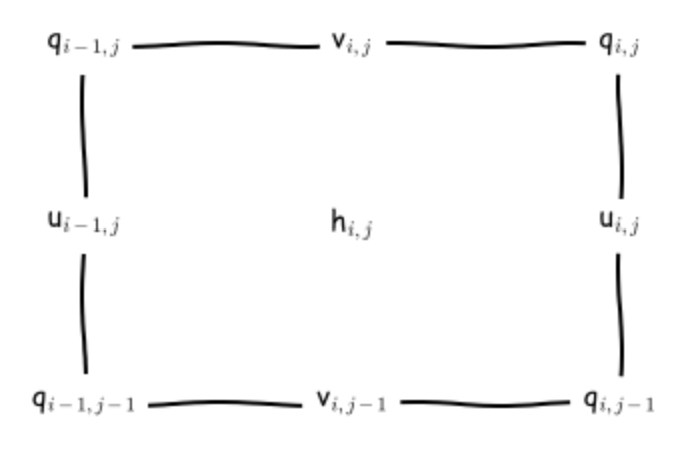

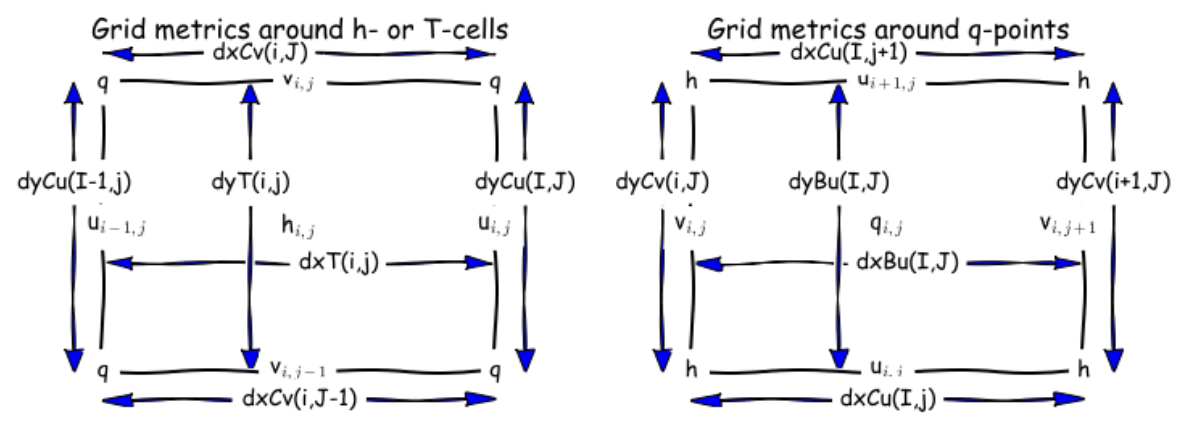

### MOM5 ocean model grid (ACCESS-OM2) 


Source

[MOM5 source code link](https://github.com/mom-ocean/MOM5/blob/6bdbdd4892543bbade921fa3224b2530d93c6f40/src/mom5/ocean_core/ocean_grids.F90#L437-L494)

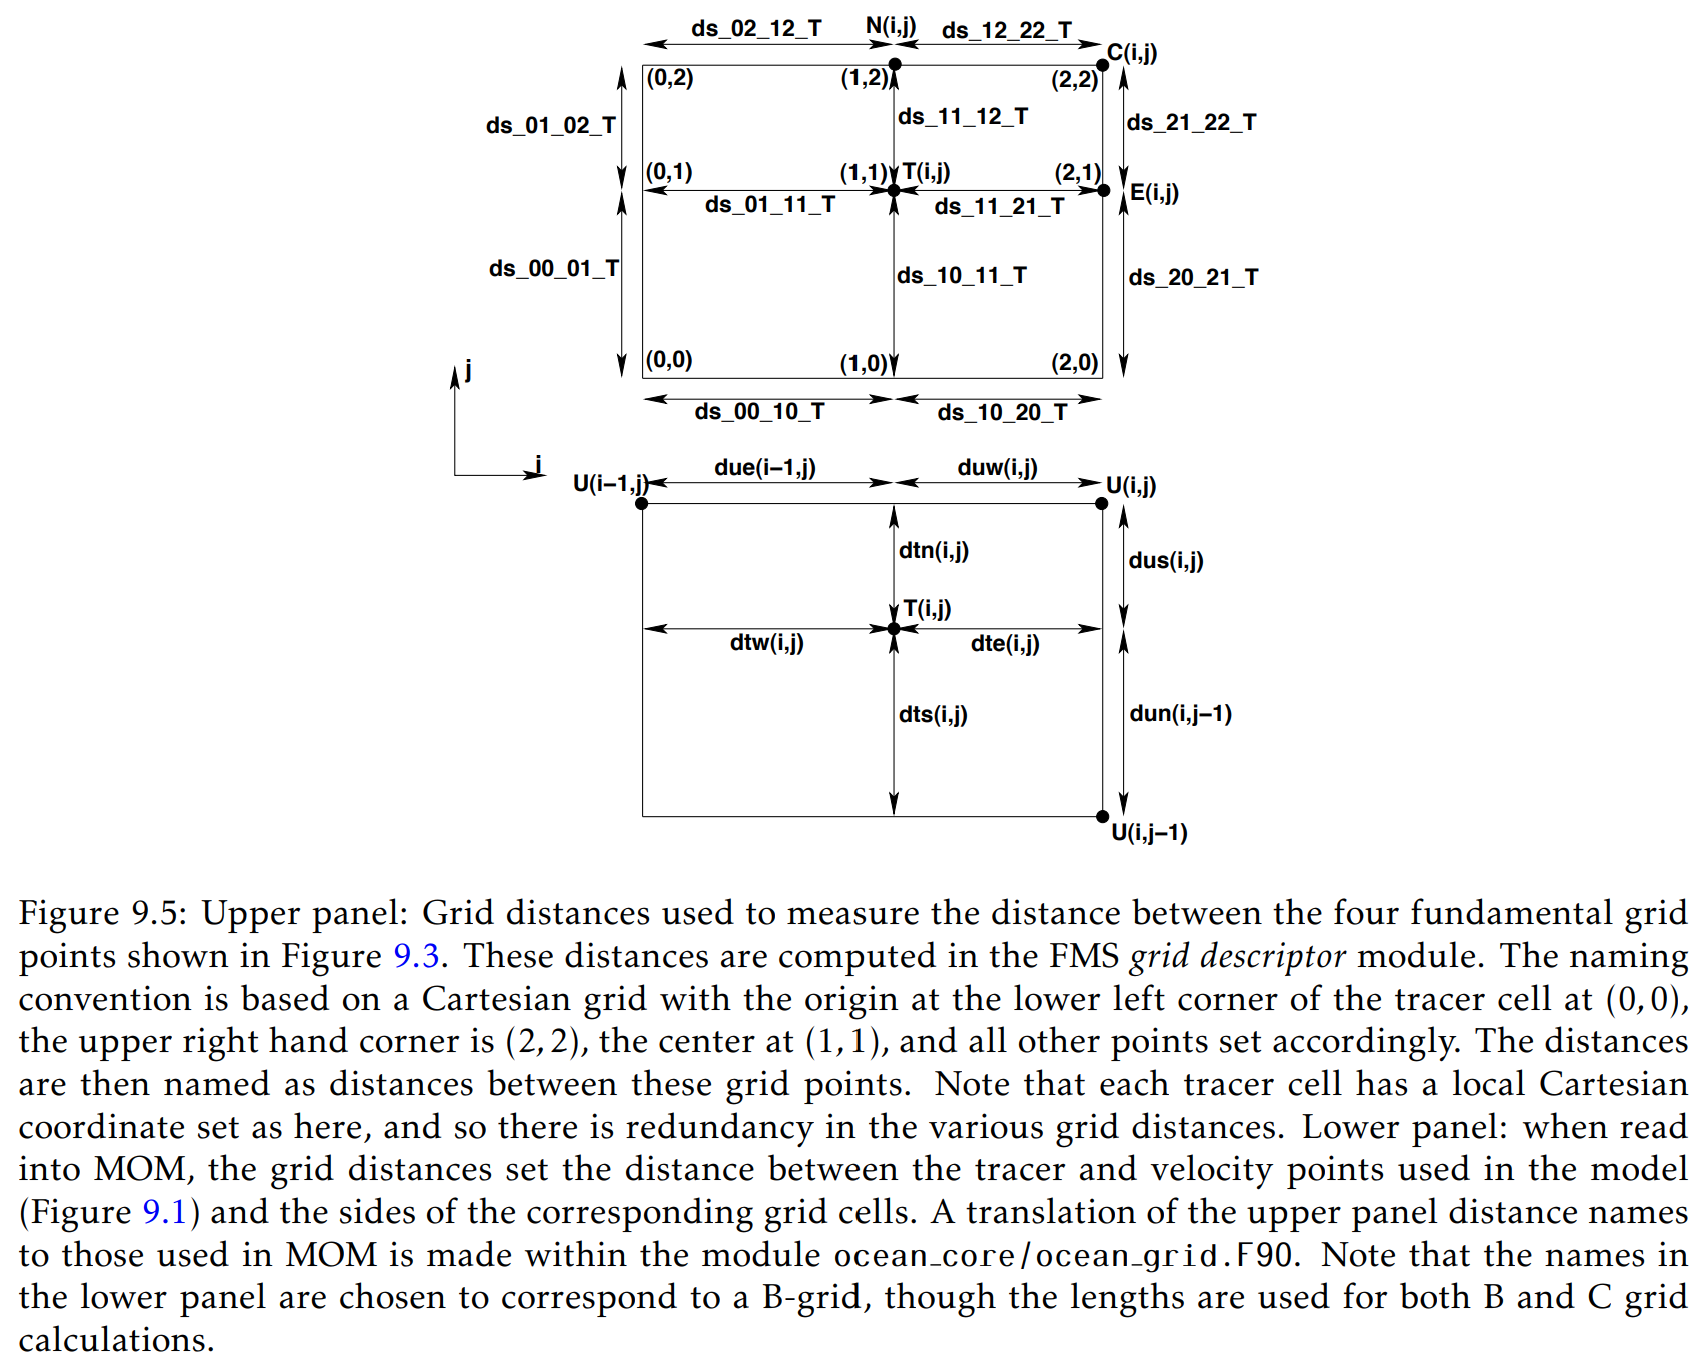

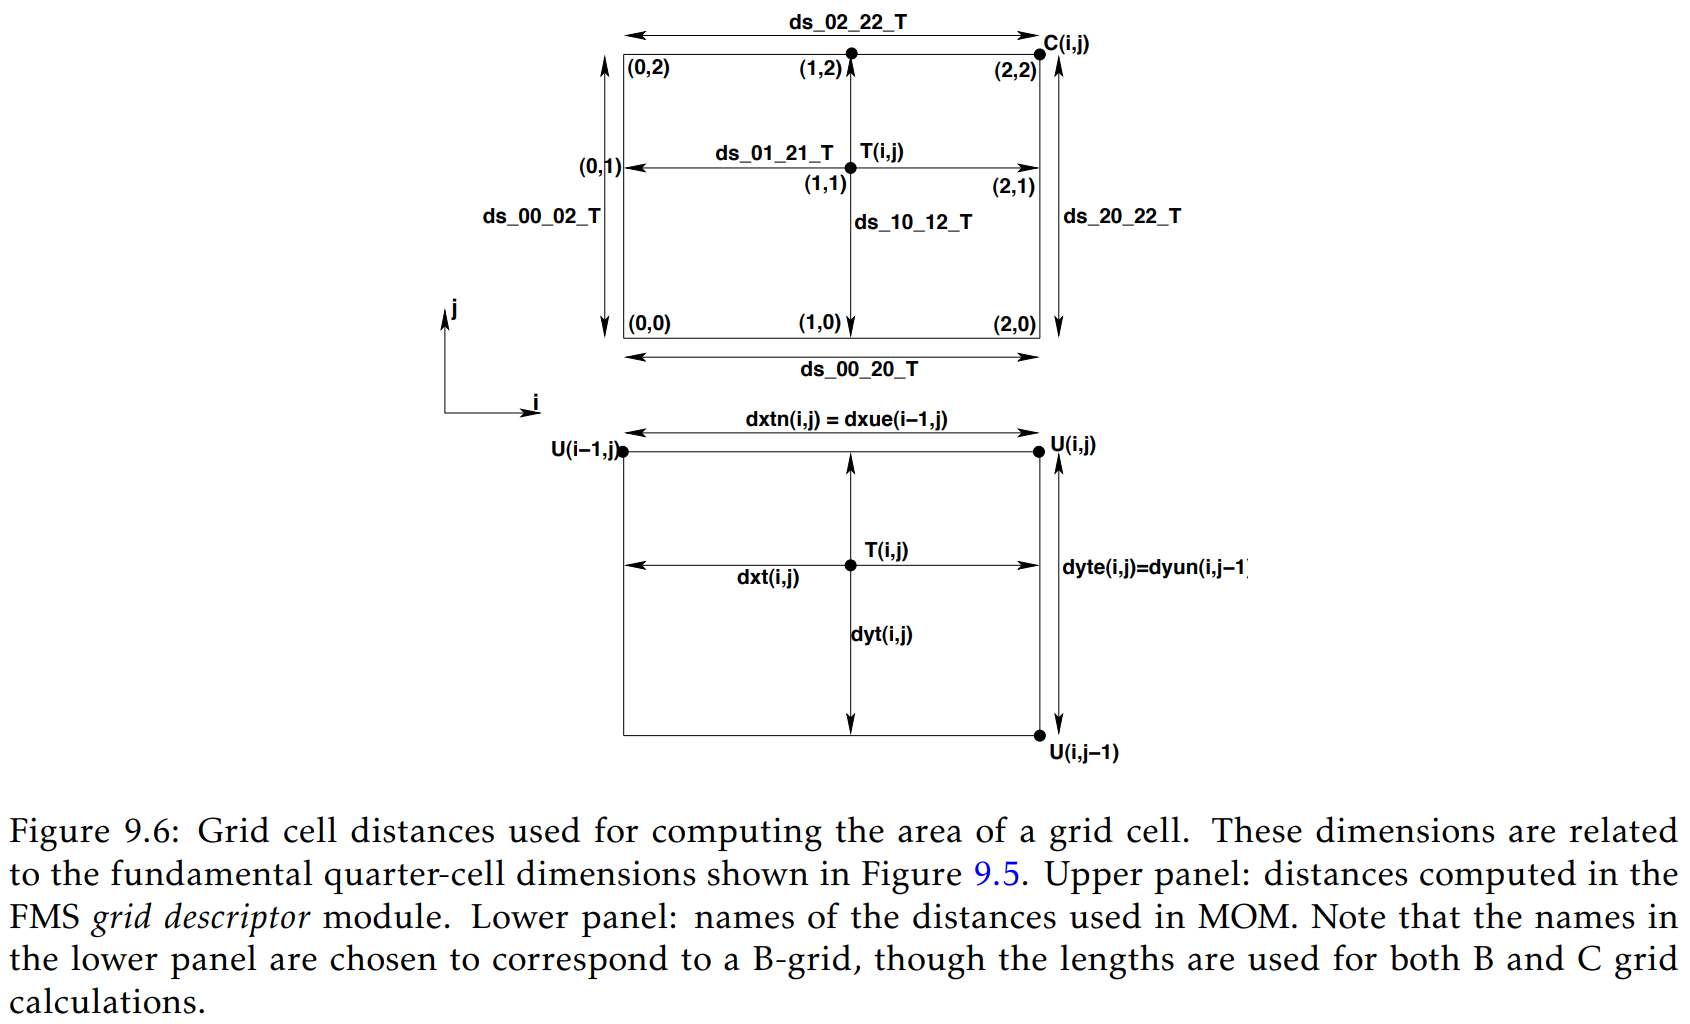

### XGCM


`XGCM` has two levels of functionality that require different amounts of setup: 
 1. The easiest (less powerful) way to use `XGCM` is to define a grid. This creates a data construct that is aware of how the grid is staggered.
 1. The trickier (more powerful) way to use `XGCM` is to define a grid *and* 


Idea how speed is trivial in mom5 not mom6 and vice versa. Then do vorticity and it's the other way around!



#### MOM5

We use a lot of the [same code from here](https://cosima-recipes.readthedocs.io/en/latest/03-Mains/Relative_Vorticity.html).

In [2]:
import intake

import xarray as xr
import cf_xarray as cfxr
import numpy as np
from dask.distributed import Client

import matplotlib.pyplot as plt
import cmocean as cm

from matplotlib import rc
import xgcm

rc("font", **{"family": "sans-serif"})
rc("text", usetex=False)

In [3]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36211,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:34685,Total threads: 1
Dashboard: /proxy/42687/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:37759,


In [4]:
catalog = intake.cat.access_nri

# values used by MOM5

Ω = 7.292e-5  # Earth's rotation rate; in radians/s
Rearth = 6371e3  # Earth's radius; in m

experiment = "025deg_jra55_iaf_omip2_cycle2"

datastore = catalog[experiment]

var_search = datastore.search(variable=["geolon_c", "geolat_c"])
var_search = var_search.search(path=var_search.df["path"][0])
grid_ds = var_search.to_dask(xarray_open_kwargs={"chunks": -1})
grid_ds = grid_ds.load()
lon = grid_ds["geolon_c"]
lat = grid_ds["geolat_c"]

f = 2 * Ω * np.sin(np.deg2rad(lat))  # convert lat in radians
f = f.rename("Coriolis")
f.attrs["long_name"] = "Coriolis parameter"
f.attrs["units"] = "s-1"
f.attrs["coordinates"] = "geolon_c geolat_c"

depth = 30  # m; avoid the surface Ekman layer by taking the "surface values" at some depth close to the surface

var_search = datastore.search(variable=["u", "v"])
ds = var_search.to_dask(xarray_open_kwargs={"chunks": {"yu_ocean": -1, "xu_ocean": -1}})

u = ds["u"].isel(time=-1).cf.sel(vertical=depth, method="nearest")
v = ds["v"].isel(time=-1).cf.sel(vertical=depth, method="nearest")

ds = xr.merge([u, v, grid_ds], compat="override")

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


At this point we have loaded in horizontal velocity ($u$,$v$) and some grid definition information (`grid_ds`). We've merged these three things into one `xarray.Dataset` called `ds`. Let's take a look at the variables in `ds`:

In [5]:
ds.data_vars

Data variables:
    u           (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    v           (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ht          (yt_ocean, xt_ocean) float32 6MB nan nan nan nan ... nan nan nan
    hu          (yu_ocean, xu_ocean) float32 6MB nan nan nan nan ... nan nan nan
    dxt         (yt_ocean, xt_ocean) float32 6MB nan nan nan nan ... nan nan nan
    dyt         (yt_ocean, xt_ocean) float32 6MB nan nan nan nan ... nan nan nan
    dxu         (yu_ocean, xu_ocean) float32 6MB nan nan nan nan ... nan nan nan
    dyu         (yu_ocean, xu_ocean) float32 6MB nan nan nan nan ... nan nan nan
    area_t      (yt_ocean, xt_ocean) float32 6MB nan nan nan nan ... nan nan nan
    area_u      (yu_ocean, xu_ocean) float32 6MB nan nan nan nan ... nan nan nan
    kmt         (yt_ocean, xt_ocean) float32 6MB nan nan nan nan ... nan nan nan
    kmu         (yu_ocean, xu_ocean) float32 6MB nan 

Let's take a look at the coordinates in `ds`:

In [6]:
ds.coords

Coordinates:
  * time      (time) datetime64[ns] 8B 1958-12-30
    st_ocean  float64 8B 30.36
  * xu_ocean  (xu_ocean) float64 12kB -279.8 -279.5 -279.2 ... 79.5 79.75 80.0
  * yu_ocean  (yu_ocean) float64 9kB -81.02 -80.92 -80.81 ... 89.79 89.89 90.0
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
    geolat_c  (yu_ocean, xu_ocean) float32 6MB nan nan nan nan ... nan nan nan
    geolon_c  (yu_ocean, xu_ocean) float32 6MB nan nan nan nan ... nan nan nan
    geolat_t  (yt_ocean, xt_ocean) float32 6MB nan nan nan nan ... nan nan nan
    geolon_t  (yt_ocean, xt_ocean) float32 6MB nan nan nan nan ... nan nan nan

At the moment, the user needs to understand how the grid is staggered from the variables names (e.g. `xu_ocean` is the nominal longitude on `u`-points), xarray and numpy have no knowledge of this but `XGCM` is here to help! There's a useful description of how the `Grid` `XGCM` grid object works [here](https://xgcm.readthedocs.io/en/latest/grids.html). 

In [8]:
ds.coords["xt_ocean"].attrs.update(axis="X")
ds.coords["xu_ocean"].attrs.update(axis="X", c_grid_axis_shift=0.5)
ds.coords["yt_ocean"].attrs.update(axis="Y")
ds.coords["yu_ocean"].attrs.update(axis="Y", c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=["X"])

In [12]:
grid

<xgcm.Grid>
X Axis (periodic, boundary='periodic'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (periodic, boundary='periodic'):
  * center   yt_ocean --> right
  * right    yu_ocean --> center

In [8]:
vx = grid.interp(grid.diff(ds.v, "X") / grid.interp(ds.dxu, "X"), "Y", boundary="extend")
uy = grid.interp(grid.diff(ds.u, "Y", boundary="extend") / grid.interp(ds.dyt, "X"), "X")

ζ_xgcm = vx - uy

ζ_xgcm = ζ_xgcm.rename("Relative Vorticity")
ζ_xgcm.attrs["long_name"] = "Relative Vorticity, ∂v/∂x-∂u/∂y"
ζ_xgcm.attrs["units"] = "s-1"

#### MOM6




 - https://xgcm.readthedocs.io/en/latest/xgcm-examples/03_MOM6.html
 - https://mom6-analysiscookbook.readthedocs.io/en/latest/notebooks/getting_started.html#Building-an-xgcm-grid-object
 - https://mom6-analysiscookbook.readthedocs.io/en/latest/notebooks/vorticity.html

In [ ]:
# for non-symmetric
# SYMMETRIC_MEMORY_ = False
# see https://xgcm.readthedocs.io/en/latest/xgcm-examples/03_MOM6.html#xgcm-grid-definition
# and https://xgcm.readthedocs.io/en/latest/grid_metrics.html#Using-metrics-with-xgcm
grid = xgcm.Grid(static,
                 coords={'X': {'center': 'xh', 'right': 'xq'},
                         'Y': {'center': 'yh', 'right': 'yq'},},
                         # 'Z': { 'inner': 'zl', 'outer': 'zi'}},
                 metrics = {
                        ('X',): ['dxt', 'dxCu', 'dxCv'], # X distances
                        ('Y',): ['dyt', 'dyCu', 'dyCv'], # Y distances
                        ('X', 'Y'): ['areacello', 'areacello_cu', 'areacello_cv', 'areacello_bu'] # Areas
                        },
                 periodic=['X'])

In [5]:
#works on 25.08
import xarray as xr
import xgcm
print("xgcm version ", xgcm.__version__)

static = xr.open_dataset("/g/data/ik11/outputs/access-om3-025/grid/access-om3.mom6.static.nc")
#these two lines were found to be necessary for xgcm 0.9.0 (`analysis3-25.09`) but not 0.8.1 (`analysis3-25.08`)
static.coords["xq"].attrs.update(axis="X", c_grid_axis_shift=0.5)
static.coords["yq"].attrs.update(axis="Y", c_grid_axis_shift=0.5)

xgcm version  0.9.0


In [6]:
static.coords

Coordinates:
  * xh       (xh) float64 12kB -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
  * yh       (yh) float64 9kB -80.94 -80.87 -80.81 -80.74 ... 89.74 89.84 89.95
  * time     (time) object 8B 1900-01-01 00:00:00
  * xq       (xq) float64 12kB -279.8 -279.5 -279.2 -279.0 ... 79.5 79.75 80.0
  * yq       (yq) float64 9kB -80.9 -80.84 -80.77 -80.71 ... 89.79 89.9 90.0

In [9]:
grid = xgcm.Grid(static,
                 coords={'X': {'center': 'xh', 'right': 'xq'},
                         'Y': {'center': 'yh', 'right': 'yq'},},
                         # 'Z': { 'inner': 'zl', 'outer': 'zi'}},
                 periodic=['X'],autoparse_metadata=False)

In [10]:
grid

<xgcm.Grid>
X Axis (periodic, boundary='periodic'):
  * center   xh --> right
  * right    xq --> center
Y Axis (periodic, boundary='periodic'):
  * center   yh --> right
  * right    yq --> center

In [1]:
import xarray as xr
import xgcm
print("xgcm version ", xgcm.__version__)

static = xr.open_dataset("/g/data/ik11/outputs/access-om3-025/grid/access-om3.mom6.static.nc")

grid = xgcm.Grid(static,
                 coords={'X': {'center': 'xh', 'right': 'xq'},
                         'Y': {'center': 'yh', 'right': 'yq'},},
                         # 'Z': { 'inner': 'zl', 'outer': 'zi'}},
                 metrics = {
                        ('X',): ['dxt', 'dxCu', 'dxCv'], # X distances
                        ('Y',): ['dyt', 'dyCu', 'dyCv'], # Y distances
                        ('X', 'Y'): ['areacello', 'areacello_cu', 'areacello_cv', 'areacello_bu'] # Areas
                        },
                 periodic=['X'])

xgcm version  0.8.1


In [2]:
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xh --> right
  * right    xq --> center
Y Axis (not periodic, boundary=None):
  * center   yh --> right
  * right    yq --> center